In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import glob
import pickle
from torch.utils.data.dataset import Dataset
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load files

In [3]:
 folder_data = glob.glob("seep_detection\\train_images_256\\*.tif")
 folder_mask = glob.glob("seep_detection\\train_masks_256\\*.tif")

In [4]:
 len_data = len(folder_data)
 print(len_data)

790


#  Soft dice loss taken from:
https://gist.github.com/jeremyjordan/9ea3032a32909f71dd2ab35fe3bacc08#file-soft_dice_loss-py

In [5]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * torch.sum(y_pred * y_true, axes)
    denominator = torch.sum(torch.square(y_pred) + torch.square(y_true), axes)

    return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon)) 

# One-hot encode the mask into 8 channels

In [6]:
def convert_class(mask):
    # convert to unique integers for easier comparison
    mask = np.asarray(mask, np.float32)
    mask[np.round(mask, 3) == 0.004] = 1
    mask[np.round(mask, 3) == 0.008] = 2
    mask[np.round(mask, 3) == 0.012] = 3
    mask[np.round(mask, 3) == 0.016] = 4
    mask[np.round(mask, 3) == 0.020] = 5
    mask[np.round(mask, 3) == 0.024] = 6
    mask[np.round(mask, 3) == 0.028] = 7
    mask = np.asarray(mask, np.uint8)

    # One-hot encode into 8 channels
    n_classes = 8
    one_hot = np.zeros((n_classes, mask.shape[1], mask.shape[2]))
    for i, unique_value in enumerate(np.unique(mask[0])):
        one_hot[i, :, :][mask[0] == unique_value] = 1

    return torch.from_numpy(one_hot)

# Split into train/test sets

In [7]:
 train_size = 0.8

 train_image_paths = folder_data[:int(len_data*train_size)]
 test_image_paths = folder_data[int(len_data*train_size):]

 train_mask_paths = folder_mask[:int(len_data*train_size)]
 test_mask_paths = folder_mask[int(len_data*train_size):]

# Loading TIF files function taken from:
https://stackoverflow.com/questions/53530751/how-make-customised-dataset-in-pytorch-for-images-and-their-masks

In [8]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True): 
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = self.transforms(image)
        mask = self.transforms(mask)

        # convert to one-hot encoding with 8 channels
        mask = convert_class(mask)
        return t_image, mask

    def __len__(self): 
        return len(self.image_paths)

# Load into data loaders

In [9]:
BATCH_SIZE = 4

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Check if the images correspond to the masks

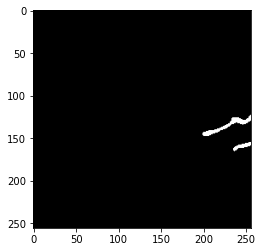

In [10]:

plt.imshow(np.uint16(train_dataset[0][1][1]*65535), cmap='gray')

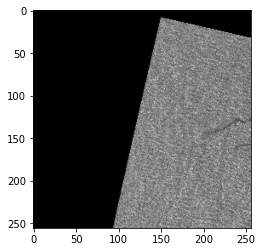

In [35]:
plt.imshow(np.uint16(train_dataset[0][0][0]), cmap='gray')

# Define our network architecture

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        ############### Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
      
        ############### Decoder
        self.conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.conv4_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.conv5_2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)

        self.conv6 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)
        self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, padding=1)

        ###############
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.batch_32 = nn.BatchNorm2d(32)
        self.batch_64 = nn.BatchNorm2d(64)
        self.batch_128 = nn.BatchNorm2d(128)


    def forward(self, x):

        ############### Encoder
        x = self.conv1(x)
        x = self.batch_32(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_32(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.batch_64(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_64(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.batch_128(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_128(x)
        x = F.relu(x)
        x = self.max_pool(x)

        ############### Dencoder
        x = self.conv4(x)
        x = self.batch_128(x)
        x = F.relu(x)
        x = self.conv4_2(x)
        x = self.batch_64(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.batch_64(x)
        x = F.relu(x)
        x = self.conv5_2(x)
        x = self.batch_32(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.batch_32(x)
        x = F.relu(x)
        x = self.conv6_2(x)
        x = F.relu(x)

        x = F.softmax(x, 1)
        return x

In [37]:
torch.manual_seed(0)
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4_2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv6_2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

# Define hyperparameter, optimizer

In [38]:
EPOCHS = 50
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model

In [39]:
def train(epochs=EPOCHS):
    train_loss = []

    for epoch in range(epochs):

        #Train mode
        model.train()
        running_loss = 0.0

        for (img, mask) in train_loader:
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()

            output = model(img.view(BATCH_SIZE, 1, 256, 256).float())

            # swap the channel to the last dimension to align with the soft dice loss function requirements
            mask = torch.transpose(mask, 1, 3)
            output = torch.transpose(output, 1, 3)
            
            # loss function
            loss = soft_dice_loss(output, mask)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss.append(avg_loss)

        print('Epoch {}, Train Loss: {:.4f}'.format(epoch+1, avg_loss))

    return train_loss

In [286]:
train_loss = train(60)

Epoch 1, Train Loss: 0.7851
Epoch 2, Train Loss: 0.7840
Epoch 3, Train Loss: 0.7824
Epoch 4, Train Loss: 0.7819
Epoch 5, Train Loss: 0.7805
Epoch 6, Train Loss: 0.7802
Epoch 7, Train Loss: 0.7772
Epoch 8, Train Loss: 0.7773
Epoch 9, Train Loss: 0.7759
Epoch 10, Train Loss: 0.7744
Epoch 11, Train Loss: 0.7744
Epoch 12, Train Loss: 0.7734
Epoch 13, Train Loss: 0.7710
Epoch 14, Train Loss: 0.7680
Epoch 15, Train Loss: 0.7685
Epoch 16, Train Loss: 0.7694
Epoch 17, Train Loss: 0.7661
Epoch 18, Train Loss: 0.7672
Epoch 19, Train Loss: 0.7659
Epoch 20, Train Loss: 0.7650


# Save and load the model

In [40]:
model = torch.load('models/final.pt')

In [41]:
#torch.save(model, 'models/final.pt')

# Display segmentation on train set (original image, predicted mask, real mask)

<Figure size 432x288 with 0 Axes>

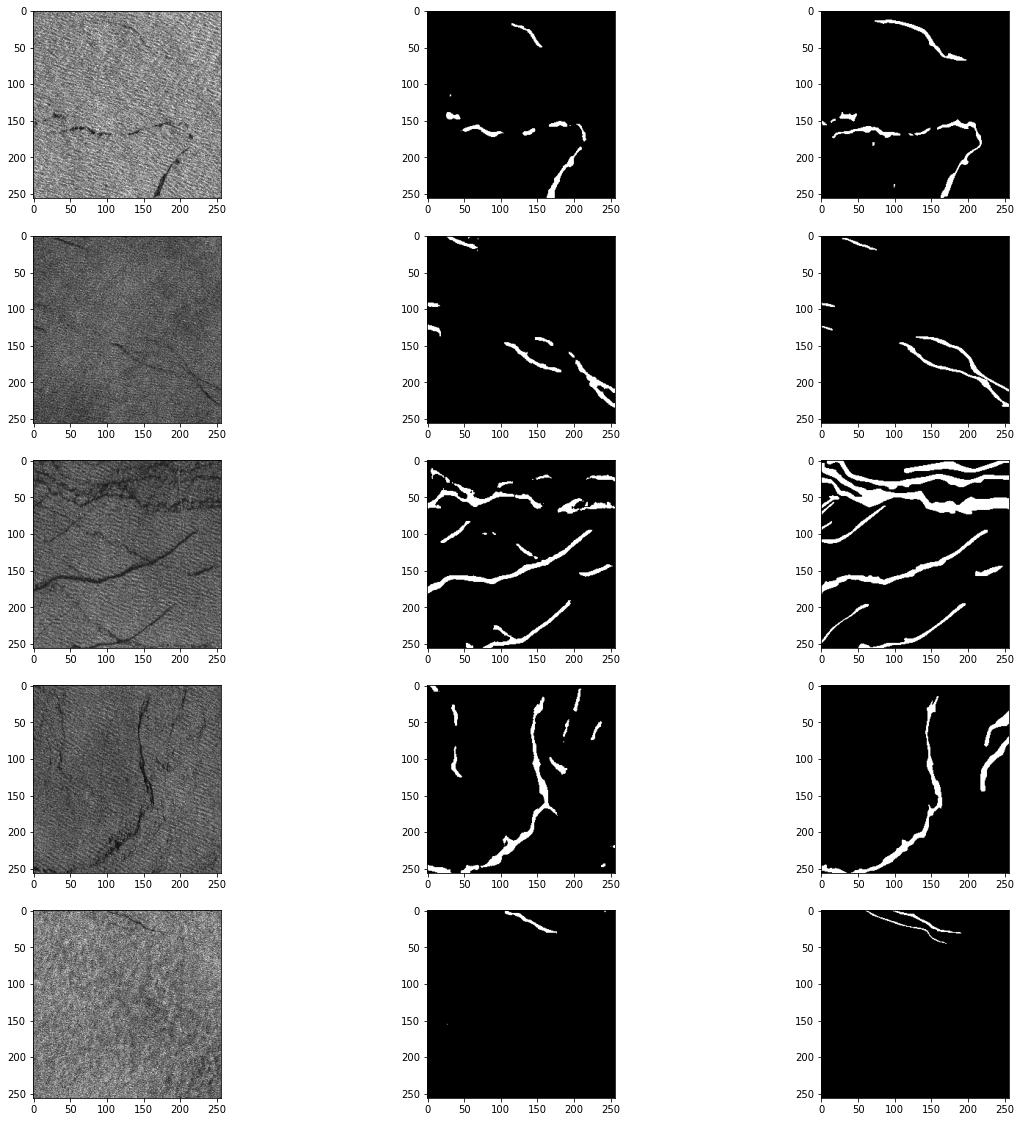

In [43]:
n = 5

plt.figure()
fig, ax = plt.subplots(n, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.2)


for i, (data, mask) in enumerate(train_loader):

    output = model(data.view(BATCH_SIZE, 1, 256, 256).to(device).float())

    data = data[0]
    data = data.squeeze(0)
    data = data.detach().cpu()
    
    prediction = output[0]
    prediction = prediction.detach().cpu()

    # class 0 (background) is conveniently multipled by 0, yielding a black label
    prediction = prediction.argmax(dim=0)
    prediction *= 65535

    temp = mask[0]
    mask = mask[0]
    mask = mask.argmax(dim=0)
    mask *= 65535

    ax[i, 0].imshow(np.uint16(data), cmap='gray')
    ax[i, 1].imshow(np.uint16(prediction), cmap='gray')
    ax[i, 2].imshow(np.uint16(mask), cmap='gray')

    if i==n-1:
        break

# Display results on test set (original image, predicted mask, real mask)

<Figure size 432x288 with 0 Axes>

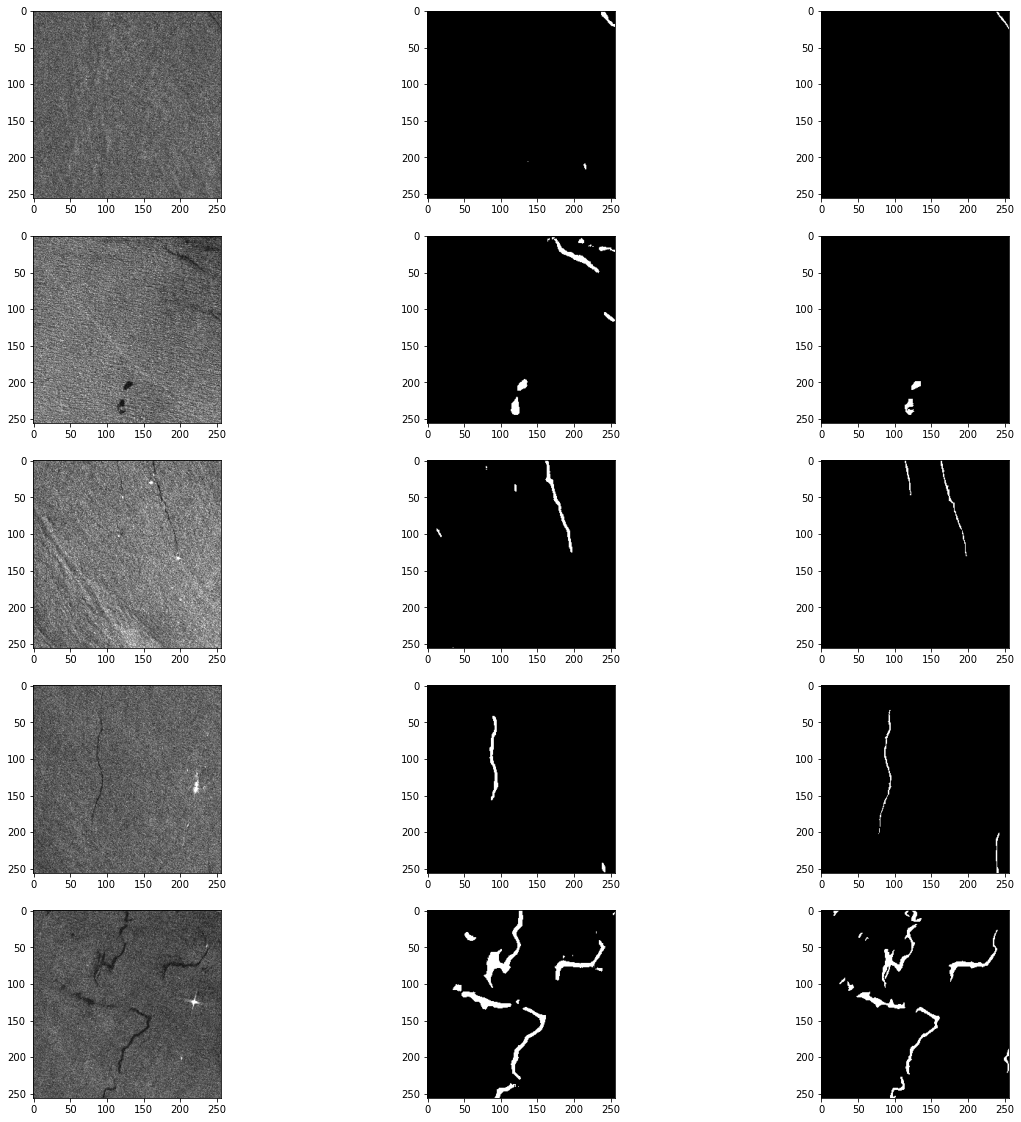

In [56]:
n = 5

plt.figure()
fig, ax = plt.subplots(n, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.2)


for i, (data, mask) in enumerate(test_loader):

    output = model(data.view(BATCH_SIZE, 1, 256, 256).to(device).float())

    data = data[0]
    data = data.squeeze(0)
    data = data.detach().cpu()
    
    prediction = output[0]
    prediction = prediction.detach().cpu()
    prediction = prediction.argmax(dim=0)
    # convert to 16 bit values
    prediction *= 65535

    temp = mask[0]
    mask = mask[0]
    mask = mask.argmax(dim=0)
    # convert to 16 bit values
    mask *= 65535

    ax[i, 0].imshow(np.uint16(data), cmap='gray')
    ax[i, 1].imshow(np.uint16(prediction), cmap='gray')
    ax[i, 2].imshow(np.uint16(mask), cmap='gray')

    if i==n-1:
        break